In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model, metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

np.random.seed(0)

In [3]:
def convert(df: pd.DataFrame, frame_size=11):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
#     x = x[x.shape[0]//10:-x.shape[0]//10]
    return x

In [4]:
from joblib import dump,load
#dump(reg, 'Model4flowSense4.joblib')
reg = load('Model5flowSense6.joblib')

/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DummyRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 0.24.2 when using version 1.0.1. This might 

In [5]:
data_dir = Path("./Noise-Study") 
df1 = pd.read_csv(data_dir / "fft_real_ambient.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1)

X = df[:,:-1]
X = X[:,:6]
X.shape

pred = reg.predict(X)

y = df[:, -2]

print("MSE: ", mean_squared_error(pred,y))

MSE:  27.234331259239834


In [104]:
data_dir = Path("./Noise-Study")
df1 = pd.read_csv(data_dir / "fft_2_people.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1)

print(df[0])
indices = range(9000,11500)

X = df[:,:-1]
X = X[indices,:6]
X.shape

pred = np.sum(X, axis = 1)
print(len(pred))

rms = df[indices, -1]

y = df[indices, -2]
y.shape

from scipy.signal import butter,filtfilt

# Filter requirements.
T = len(y)*10             # Sample Period (total number of samples * 10, because 0.1hz sampling rate)
fs = 0.1               # sample rate, Hz (one sample per 10 seconds)
low_cutoff = 1.5      # desired cutoff frequency of the low-pass filter, Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 3       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff * nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y1 = butter_lowpass_filter(y, low_cutoff, fs, order)

[38.         46.0297     20.3398      7.8594     20.8806     11.1915
  8.6194      3.7744     14.         28.44        8.16805823]
2500


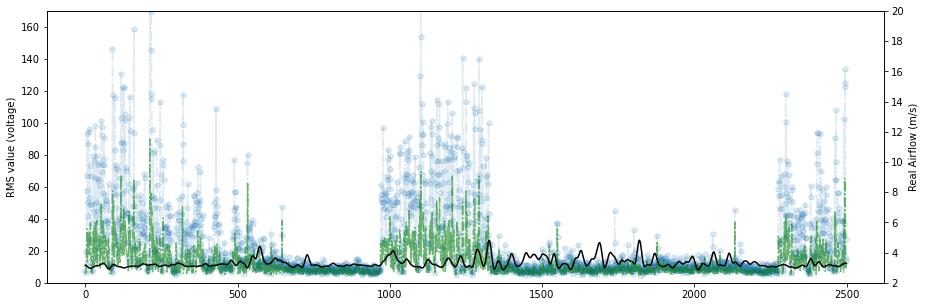

In [155]:
pred[1738] = 450

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
l2, = ax1.plot(rms, 'p-.', alpha = 0.15)
l0, = ax1.plot(pred/50+3.1, 'g-.', alpha = 0.55)
l1, = ax2.plot(y1, 'k-', alpha = 1.0)

# Put a legend to the right of the current axis
#plt.legend((l0, l1, l2), ('Low Frequency Component of Noise', 'Actual Airflow', 'Ambient Noise'), shadow=True, loc='upper right')
ax2.set_ylabel("Real Airflow (m/s)")
ax2.set_ylim(2, 20)
ax1.set_ylabel("RMS value (voltage)")
ax1.set_ylim(0, 170)
fig1.set_size_inches(15, 5, forward=True)
fig1.patch.set_facecolor('white')
plt.savefig("fig3.png", bbox_inches="tight")

[ 22.      49.5354  99.17    58.527  137.4191  31.7025 352.7     93.015
 174.       8.03  ]


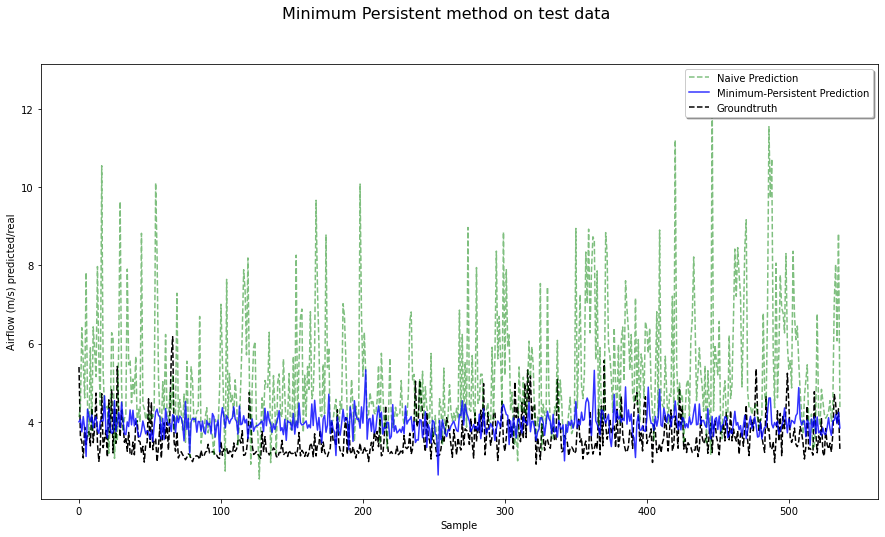

In [101]:
######################## IMPLEMENTING PERSISTENT MINIMUM SCHEME ####

def avg(lst):
    return sum(lst) / len(lst)

def getPersistentMinimum(inp, num=5, epsilon=0.5):
    window = [inp[0]]
    for i in range(1, len(inp)):
        if abs(inp[i] - avg(window)) > epsilon: #if this prediction deviates from the running mean by more than epsilon...
            window = [inp[i]]    #start over, reset our window size
        else:
            window.append(inp[i])
        if len(window) == int(num):
            return avg(window)
    return 0

data_dir = Path("./Noise-Study")
df1 = pd.read_csv(data_dir / "fft_real_ambient.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df = convert(df1, frame_size=10)

print(df[0])

predictions = []
minimumPersistent = []
totalMinimum = []
groundtruths = []
tempPred = []
tempGround = []

for i in range(1, df.shape[0]):
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-1])
    if i % 15 == 0:
        tempPred.sort()
        perMin = getPersistentMinimum(tempPred)
        if (perMin != 0):
            minimumPersistent.append(perMin)
            totalMinimum.append(tempPred[0])
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(8)
fig1.suptitle('Minimum Persistent method on test data', fontsize=16)
l1, = ax1.plot(groundtruths, 'k--', alpha = 1)
l0, = ax1.plot(predictions, 'g--', alpha = 0.5)
l2, = ax1.plot(minimumPersistent, 'b-', alpha = 0.8)
#l3, = ax1.plot(totalMinimum, 'p-', alpha = 0.2)
ax1.legend((l0, l2, l1), ('Naive Prediction', 'Minimum-Persistent Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

In [7]:
#Looking at predictions with different candidate parameters for MPS

data_dir = Path("./Noise-Study")
df1 = pd.read_csv(data_dir / "fft_real_ambient.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

def MPS(s, n, e):
    predictions = []
    minimumPersistent = []
    groundtruths = []
    tempPred = []
    tempGround = []

    for i in range(1, df.shape[0]):
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-1])
        if i % s == 0:
            tempPred.sort()
            minimumPersistent.append(getPersistentMinimum(tempPred, num = n, epsilon = e))
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []
    print("Num Samples: {}, Window Size: {}, epsilon: {}".format(s,n,e))
    print("Standard MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    print("MinimumPersistent MSE: {}".format(mean_squared_error(minimumPersistent, groundtruths)))
    print("")

#num samples = 15, window size 5, epsilon 0.75
samples = 15
n = 5
e = 0.75
MPS(samples, n, e)

#num samples = 25, window size 5, epsilon 0.75
samples = 25
n = 5
e = 0.75
MPS(samples, n, e)

#num samples = 15, window size 5, epsilon 0.5
samples = 15
n = 5
e = 0.50
MPS(samples, n, e)

#num samples = 25, window size 5, epsilon 0.5
samples = 25
n = 5
e = 0.50
MPS(samples, n, e)

#num samples = 15, window size 7, epsilon 0.5
samples = 15
n = 7
e = 0.50
MPS(samples, n, e)

#num samples = 25, window size 7, epsilon 0.5
samples = 25
n = 7
e = 0.50
MPS(samples, n, e)

#num samples = 15, window size 3, epsilon 0.5
samples = 15
n = 3
e = 0.50
MPS(samples, n, e)

#num samples = 25, window size 3, epsilon 0.5
samples = 25
n = 3
e = 0.50
MPS(samples, n, e)

Num Samples: 15, Window Size: 5, epsilon: 0.75
Standard MSE: 6.570235281067255
MinimumPersistent MSE: 1.0590401984329256



/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)


Num Samples: 25, Window Size: 5, epsilon: 0.75
Standard MSE: 5.544224957952375
MinimumPersistent MSE: 0.35643697620236203



/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)


Num Samples: 15, Window Size: 5, epsilon: 0.5
Standard MSE: 6.570235281067255
MinimumPersistent MSE: 2.184722412172042

Num Samples: 25, Window Size: 5, epsilon: 0.5
Standard MSE: 5.544224957952375
MinimumPersistent MSE: 0.3673769729532772



/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-o

Num Samples: 15, Window Size: 7, epsilon: 0.5
Standard MSE: 6.570235281067255
MinimumPersistent MSE: 5.024700824959137

Num Samples: 25, Window Size: 7, epsilon: 0.5
Standard MSE: 5.544224957952375
MinimumPersistent MSE: 0.973247874924996



/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-o

Num Samples: 15, Window Size: 3, epsilon: 0.5
Standard MSE: 6.570235281067255
MinimumPersistent MSE: 0.5963782153159957

Num Samples: 25, Window Size: 3, epsilon: 0.5
Standard MSE: 5.544224957952375
MinimumPersistent MSE: 0.7284577456518158



/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)


17070
[152.          30.5054      34.7626      51.4435      29.1204
  28.0821      96.9513      25.0277       8.           3.36
  16.80400398]


/Users/adam/miniforge3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


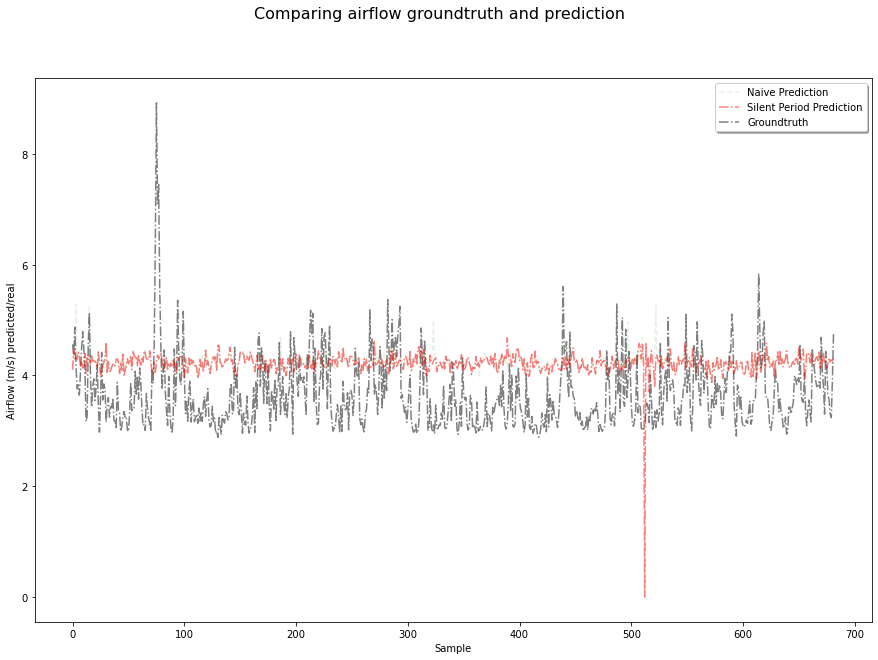

In [8]:
######################## IMPLEMENTING SILENT PERIODS SCHEME ####

def getForSilentPeriods(inp, rms, threshold=15):
    silentPreds = []
    for i in range(0, len(inp)):
        if rms[i] < threshold:   # if it was silent during this prediction
            silentPreds.append(inp[i])   # then add this to the list
    if len(silentPreds) > 0:
        return avg(silentPreds)
    else:
        return 0
    
def getForSilentPeriodsWithAveraging(inp, rms, threshold=15):
    if avg(rms) < threshold:   # if it was silent during this prediction
        return avg(inp)
    else:
        return 0

data_dir = Path("./Noise-Study")
df1 = pd.read_csv(data_dir / "fft_music.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)
print(df.shape[0])

print(df[0])
indices = range(10000,15000)

predictions = []
silentPeriods = []
silentPeriodsAvg = []
groundtruths = []
rms = []
tempPred = []
tempGround = []

for i in range(1, df.shape[0]):
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-2])
    rms.append(df[i][-1])
    
    if i % 25 == 0:
        silentPeriods.append(getForSilentPeriods(tempPred, rms))
        silentPeriodsAvg.append(getForSilentPeriodsWithAveraging(tempPred, rms))
        predictions.append(sum(tempPred)/len(tempPred))
        groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []
        rms = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing airflow groundtruth and prediction', fontsize=16)
l1, = ax1.plot(groundtruths, 'k-.', alpha = 0.5)
l0, = ax1.plot(predictions, 'g--', alpha = 0.1)
#l2, = ax1.plot(silentPeriods, 'r-.', alpha = 0.5)
l2, = ax1.plot(silentPeriods, 'r-.', alpha = 0.5)
ax1.legend((l0, l2, l1), ('Naive Prediction', 'Silent Period Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

In [9]:
###### FILTER BY SILENT THRESHOLDS AND GET PERCENTAGES

def filtering(threshold):
    return df[df[:,-1]<threshold]
    
print("Size of input: ", len(df))
print("Size of filtered by RMS 15: ", len(filtering(15)))
print("Size of filtered by RMS 25: ", len(filtering(25)))
print("Size of filtered by RMS 50: ", len(filtering(50)))
print("Size of filtered by RMS 70: ", len(filtering(70)))

##Percentages

print("Percent with RMS value below 15: ", len(filtering(15))/len(df))
print("Percent with RMS value below 25: ", len(filtering(25))/len(df))
print("Percent with RMS value below 50: ", len(filtering(50))/len(df))
print("Percent with RMS value below 70: ", len(filtering(70))/len(df))


Size of input:  17070
Size of filtered by RMS 15:  14547
Size of filtered by RMS 25:  16963
Size of filtered by RMS 50:  17069
Size of filtered by RMS 70:  17070
Percent with RMS value below 15:  0.8521968365553603
Percent with RMS value below 25:  0.9937316930287053
Percent with RMS value below 50:  0.9999414176918571
Percent with RMS value below 70:  1.0


In [10]:
#Looking at predictions with different candidate parameters for Silence Detection

def SD(s, t):
    predictions = []
    silentPeriods = []
    groundtruths = []
    rms = []
    tempPred = []
    tempGround = []

    for i in range(1, df.shape[0]):
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-2])
        rms.append(df[i][-1])

        if i % 25 == 0:
            silentPeriods.append(getForSilentPeriods(tempPred, rms, threshold=t))
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []
            rms = []
    print("Num Samples: {}, Threshold: {}".format(s,t))
    print("Standard MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    
    groundtruths = np.array(groundtruths, dtype=object)
    silentPeriods = np.array(silentPeriods, dtype=object)
    
    #get rid of any failed predictions
    indices = np.where(silentPeriods == 0)
    groundtruthsFilt = np.delete(groundtruths, indices, None)
    silentPeriodsFilt = np.delete(silentPeriods, indices, None)
    print("SilentPeriods MSE: {}".format(mean_squared_error(silentPeriodsFilt, groundtruthsFilt)))
    print("")

#num samples = 15, threshold = 15
samples = 15
t = 15
SD(samples, t)

#num samples = 15, threshold = 15
t = 25
SD(samples, t)

#num samples = 15, threshold = 15
t = 50
SD(samples, t)

#num samples = 15, threshold = 15
t = 70
SD(samples, t)

#num samples = 25, threshold = 15
samples = 25
t = 15
SD(samples, t)

#num samples = 25, threshold = 15
t = 25
SD(samples, t)

#num samples = 25, threshold = 15
t = 50
SD(samples, t)

#num samples = 25, threshold = 15
t = 70
SD(samples, t)

Num Samples: 15, Threshold: 15
Standard MSE: 0.7592830603484142
SilentPeriods MSE: 0.7407960609583452

Num Samples: 15, Threshold: 25
Standard MSE: 0.7592830603484142
SilentPeriods MSE: 0.7509721858189057

Num Samples: 15, Threshold: 50
Standard MSE: 0.7592830603484142
SilentPeriods MSE: 0.7592517149912474

Num Samples: 15, Threshold: 70
Standard MSE: 0.7592830603484142
SilentPeriods MSE: 0.7592830603484142

Num Samples: 25, Threshold: 15
Standard MSE: 0.7592830603484142
SilentPeriods MSE: 0.7407960609583452

Num Samples: 25, Threshold: 25
Standard MSE: 0.7592830603484142
SilentPeriods MSE: 0.7509721858189057

Num Samples: 25, Threshold: 50
Standard MSE: 0.7592830603484142
SilentPeriods MSE: 0.7592517149912474

Num Samples: 25, Threshold: 70
Standard MSE: 0.7592830603484142
SilentPeriods MSE: 0.7592830603484142



[82.         63.7429     18.498      13.1727     33.2866     11.66
 23.3629     15.8548     14.          3.22       10.46727292]


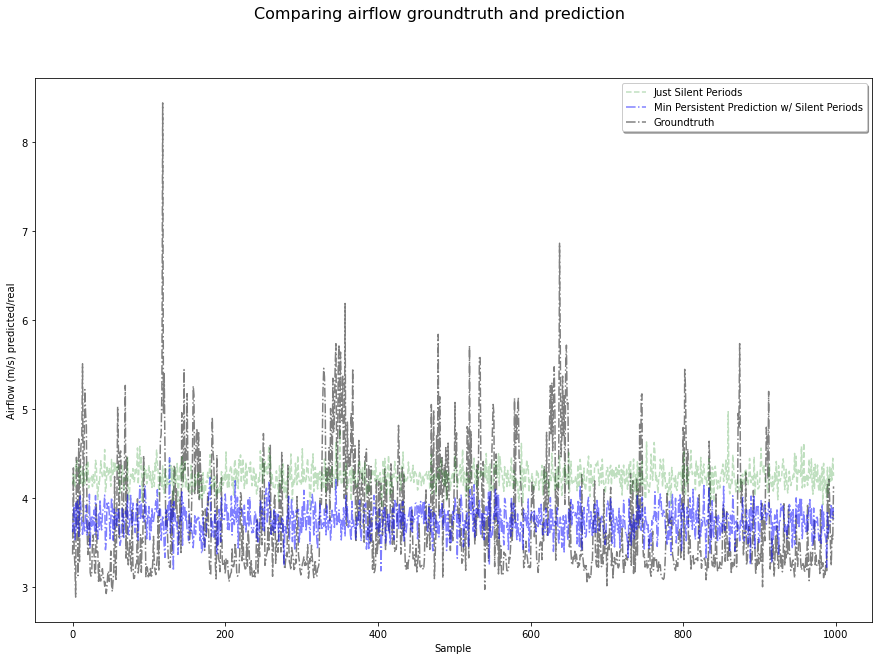

MinimumPersistent MSE:  0.44279976923165026


In [11]:
######################## IMPLEMENTING PERSISTENT MINIMUM SCHEME W SILENT PERIODS ####

def avg(lst):
    return sum(lst) / len(lst)

data_dir = Path("./Noise-Study")
df1 = pd.read_csv(data_dir / "fft_streetNoise.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

print(df[0])
indices = range(15000)

predictions = []
minimumPersistent = []
totalMinimum = []
groundtruths = []
tempPred = []
tempGround = []
threshold = 15

for i in range(1, df.shape[0]):
    if(df[i][-1] > threshold): # if rms value is larger than threshold, totally skip this data point
        tempGround.append(df[i][-2])
        continue
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-2])
    if i % 15 == 0:
        tempPred.sort()
        perMin = getPersistentMinimum(tempPred, num=3)
        if (perMin != 0):
            minimumPersistent.append(perMin)
            totalMinimum.append(tempPred[0])
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing airflow groundtruth and prediction', fontsize=16)
l1, = ax1.plot(groundtruths, 'k-.', alpha = 0.5)
l0, = ax1.plot(predictions, 'g--', alpha = 0.25)
l2, = ax1.plot(minimumPersistent, 'b-.', alpha = 0.5)
#l3, = ax1.plot(totalMinimum, 'p-', alpha = 0.2)
ax1.legend((l0, l2, l1), ('Just Silent Periods', 'Min Persistent Prediction w/ Silent Periods', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

print("MinimumPersistent MSE: ", mean_squared_error(minimumPersistent,groundtruths))

In [12]:
#Looking at predictions with different candidate parameters for MPS + SilentPeriods

data_dir = Path("./Noise-Study")
df1 = pd.read_csv(data_dir / "fft_real_ambient.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

def MPS(s, n, e, t):
    predictions = []
    minimumPersistent = []
    groundtruths = []
    tempPred = []
    tempGround = []

    for i in range(1, df.shape[0]):
        if(df[i][-1] > t): # if rms value is larger than threshold, totally skip this data point
            tempGround.append(df[i][-2])
            continue
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-2])
        if i % 15 == 0:
            tempPred.sort()
            perMin = getPersistentMinimum(tempPred, num=3)
            if (perMin != 0):
                minimumPersistent.append(perMin)
                totalMinimum.append(tempPred[0])
                predictions.append(sum(tempPred)/len(tempPred))
                groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []
    print("Num Samples: {}, Window Size: {}, epsilon: {}, RMS not-silent threshold: {}".format(s,n,e,t))
    print("Silent Periods MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    print("MinimumPersistent AND SilentPeriods MSE: {}".format(mean_squared_error(minimumPersistent, groundtruths)))
    print("")

#num samples = 15, window size 3, epsilon 0.75, threshold 15
samples = 15
n = 3
e = 0.75
t = 15
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 15
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 25
e = 0.75
t = 25
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 25
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 50
e = 0.75
t = 50
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 50
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 70
e = 0.75
t = 70
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 70
e = 0.5
MPS(samples, n, e, t)


#num samples = 15, window size 5, epsilon 0.75, threshold 15
samples = 15
n = 5
e = 0.75
t = 15
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 15
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 25
e = 0.75
t = 25
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 25
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 50
e = 0.75
t = 50
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 50
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 70
e = 0.75
t = 70
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 70
e = 0.5
MPS(samples, n, e, t)



Num Samples: 15, Window Size: 3, epsilon: 0.75, RMS not-silent threshold: 15
Silent Periods MSE: 0.691865886879655
MinimumPersistent AND SilentPeriods MSE: 0.44279976923165026

Num Samples: 15, Window Size: 3, epsilon: 0.5, RMS not-silent threshold: 15
Silent Periods MSE: 0.691865886879655
MinimumPersistent AND SilentPeriods MSE: 0.44279976923165026

Num Samples: 15, Window Size: 3, epsilon: 0.75, RMS not-silent threshold: 25
Silent Periods MSE: 0.702825335770996
MinimumPersistent AND SilentPeriods MSE: 0.44784831589309976

Num Samples: 15, Window Size: 3, epsilon: 0.5, RMS not-silent threshold: 25
Silent Periods MSE: 0.702825335770996
MinimumPersistent AND SilentPeriods MSE: 0.44784831589309976

Num Samples: 15, Window Size: 3, epsilon: 0.75, RMS not-silent threshold: 50
Silent Periods MSE: 0.7611249307582166
MinimumPersistent AND SilentPeriods MSE: 0.45179319170010623

Num Samples: 15, Window Size: 3, epsilon: 0.5, RMS not-silent threshold: 50
Silent Periods MSE: 0.7611249307582166
M

[192.          36.4181      91.2065      94.1109     164.9242
 173.4624     174.8181     141.4767     168.          13.37
  40.61590821]


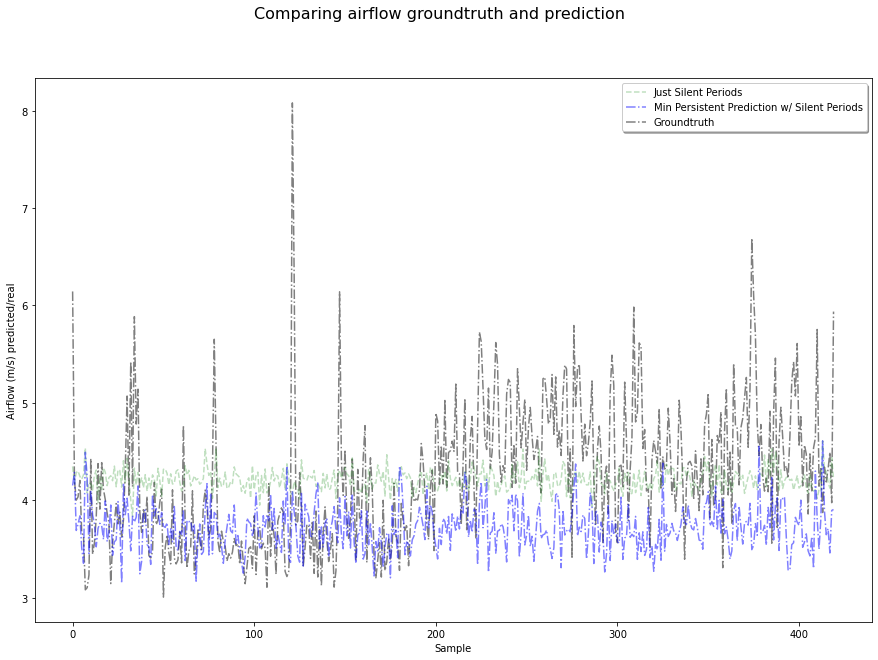

MinimumPersistent + Silent MSE:  0.7837216540220671
Just Silent Periods MSE:  0.5059297398648082
Just MPS MSE:  0.9693372206346962
Naive MSE:  14.97776656193203
Percent Improvement:  0.947674331097268


In [13]:
######################## TESTING PERSISTENT MINIMUM SCHEME W SILENT PERIODS ####

def avg(lst):
    return sum(lst) / len(lst)

data_dir = Path("./Noise-Study")
df1 = pd.read_csv(data_dir / "fft_3_people.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

print(df[0])

predictions = []
mpsSilent = []
groundtruths = []
tempPred = []
tempGround = []
threshold = 15

for i in range(1, df.shape[0]):
    if(df[i][-1] > threshold): # if rms value is larger than threshold, totally skip this data point
        tempGround.append(df[i][-2])
        continue
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-2])
    if i % 25 == 0:
        tempPred.sort()
        perMin = getPersistentMinimum(tempPred, num=5)
        if (perMin != 0):
            mpsSilent.append(perMin)
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []

justMPS = []
justMPSgroundtruths = []
tempPred = []
tempGround = []
for i in range(1, df.shape[0]):
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-2])
    if i % 25 == 0:
        tempPred.sort()
        perMin = getPersistentMinimum(tempPred, num=5)
        if (perMin != 0):
            justMPS.append(perMin)
            justMPSgroundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing airflow groundtruth and prediction', fontsize=16)
l1, = ax1.plot(groundtruths, 'k-.', alpha = 0.5)
l0, = ax1.plot(predictions, 'g--', alpha = 0.25)
l2, = ax1.plot(mpsSilent, 'b-.', alpha = 0.5)
#l3, = ax1.plot(totalMinimum, 'p-', alpha = 0.2)
ax1.legend((l0, l2, l1), ('Just Silent Periods', 'Min Persistent Prediction w/ Silent Periods', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

mpsMSE = mean_squared_error(mpsSilent,groundtruths)
print("MinimumPersistent + Silent MSE: ", mpsMSE)

justSilentMSE = mean_squared_error(predictions,groundtruths)
print("Just Silent Periods MSE: ", justSilentMSE)

justMPSMSE = mean_squared_error(justMPS,justMPSgroundtruths)
print("Just MPS MSE: ", justMPSMSE)

X = df[:,:-1]
X = X[:,:6]
X.shape

naive = reg.predict(X)

y = df[:, -2]

naiveMSE = mean_squared_error(naive,y)
print("Naive MSE: ", naiveMSE)

print("Percent Improvement: ", (1-mpsMSE/naiveMSE))

In [17]:
#Looking at predictions with different candidate parameters for MPS + SilentPeriods

data_dir = Path("./RealWorld")
df1 = pd.read_csv(data_dir / "fft_2_O_P1_INHAND.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

def MPS(s, n, e, t, range):
    predictions = []
    minimumPersistent = []
    groundtruths = []
    tempPred = []
    tempGround = []

    for i in range:
        if(df[i][-1] > t): # if rms value is larger than threshold, totally skip this data point
            tempGround.append(df[i][-2])
            continue
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-2])
        if i % 15 == 0:
            tempPred.sort()
            perMin = getPersistentMinimum(tempPred, num=3)
            if (perMin != 0):
                minimumPersistent.append(perMin)
                totalMinimum.append(tempPred[0])
                predictions.append(sum(tempPred)/len(tempPred))
                groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []

    X = df[:,:-1]
    X = X[range,:6]
    X.shape

    naive = reg.predict(X)

    y = df[range, -2]

    naiveMSE = mean_squared_error(naive,y)
    print("Num Samples: {}, Window Size: {}, epsilon: {}, RMS not-silent threshold: {}".format(s,n,e,t))
    print("Naive MSE: {}".format(naiveMSE))
    print("Silent Periods MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    print("MinimumPersistent AND SilentPeriods MSE: {}".format(mean_squared_error(minimumPersistent, groundtruths)))
    print("")

def justMPS(s, n, e, t, range):
    predictions = []
    minimumPersistent = []
    groundtruths = []
    tempPred = []
    tempGround = []

    for i in range:
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-2])
        if i % s == 0:
            tempPred.sort()
            minimumPersistent.append(getPersistentMinimum(tempPred, num = n, epsilon = e))
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []
    print("Num Samples: {}, Window Size: {}, epsilon: {}".format(s,n,e))
    print("Naive MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    print("Just MinimumPersistent MSE: {}".format(mean_squared_error(minimumPersistent, groundtruths)))
    print("")

samples = 25
n = 5
e = 0.5
t = 60
MPS(samples, n, e, t, range(0,1000))

MPS(samples, n, e, t, range(1000,2000))

MPS(samples, n, e, t, range(2000,3000))

MPS(samples, n, e, t, range(3000,4000))

MPS(samples, n, e, t, range(4000,5000))

MPS(samples, n, e, t, range(5000,6000))

MPS(samples, n, e, t, range(6000,7000))

# justMPS(samples, n, e, t, range(1000,2000))
#
# justMPS(samples, n, e, t, range(2000,3000))
#
# justMPS(samples, n, e, t, range(3000,4000))
#
# justMPS(samples, n, e, t, range(4000,5000))
#
# justMPS(samples, n, e, t, range(5000,6000))

print(avg([2.7158351632886806, 6.393329479297131, 5.526536676502199, 4.763946675986667, 4.545743024000046]))

Num Samples: 25, Window Size: 5, epsilon: 0.5, RMS not-silent threshold: 60
Naive MSE: 21.358204859353386
Silent Periods MSE: 7.148672265387739
MinimumPersistent AND SilentPeriods MSE: 8.52401063280789

Num Samples: 25, Window Size: 5, epsilon: 0.5, RMS not-silent threshold: 60
Naive MSE: 8.369986558320273
Silent Periods MSE: 2.512353486313803
MinimumPersistent AND SilentPeriods MSE: 4.545743024000046

Num Samples: 25, Window Size: 5, epsilon: 0.5, RMS not-silent threshold: 60
Naive MSE: 6.127552532585682
Silent Periods MSE: 2.8571426851174326
MinimumPersistent AND SilentPeriods MSE: 4.763946675986667

Num Samples: 25, Window Size: 5, epsilon: 0.5, RMS not-silent threshold: 60
Naive MSE: 6.54031571426974
Silent Periods MSE: 3.496785346559656
MinimumPersistent AND SilentPeriods MSE: 5.526536676502199

Num Samples: 25, Window Size: 5, epsilon: 0.5, RMS not-silent threshold: 60
Naive MSE: 6.895729461979769
Silent Periods MSE: 4.124656845607719
MinimumPersistent AND SilentPeriods MSE: 6.39

IndexError: index 6208 is out of bounds for axis 0 with size 6208

In [15]:
######################## TESTING PERSISTENT MINIMUM SCHEME W SILENT PERIODS ####

def avg(lst):
    return sum(lst) / len(lst)

from joblib import dump,load
from sklearn.metrics import accuracy_score

#dump(clf, '6FeatflowClassifer.joblib')
clf = load('6FeatflowClassifer.joblib')

data_dir = Path("./Noise-Study")
df1 = pd.read_csv(data_dir / "fft_streetNoise.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

naivePred = []
tempPred = []
threshold = 60

for i in range(1, df.shape[0]):
    X = df[i,:6]
    if(df[i][-1] < threshold): # if rms value is larger than threshold, totally skip this data point
        tempPred.append(clf.predict(X.reshape(1, -1)))
    naivePred.append(clf.predict(X.reshape(1, -1)))

print("accuracy without silent periods:")
print(accuracy_score(naivePred, np.ones(len(naivePred))))

print("accuracy with silent periods:")
print(accuracy_score(tempPred, np.ones(len(tempPred))))

/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.24.2 when using version 1.0.1. This migh

accuracy without silent periods:
0.6453129023950553
accuracy with silent periods:
0.6454522030404535
